This notebook explore the publications citing Galaxy using the [Google Scholar profile](https://scholar.google.de/citations?hl=de&user=3tSiRGoAAAAJ) with all major publications of the Galaxy Project. We use it to extract the citations for the papers using Semantic Search (Google Scholar blocking requests on citations)

In [1]:
import datetime
import matplotlib.pyplot as plt
import os
import pandas as pd
import pprint
import re
import requests
import time

from pathlib import Path
from pyzotero import zotero
from scholarly import ProxyGenerator, scholarly

In [2]:
figure_dp = Path("../figures/")
figure_dp.mkdir(parents=True, exist_ok=True)

data_dp = Path("../data/")
data_dp.mkdir(parents=True, exist_ok=True)

In [3]:
def start_proxy():
    success = pg.FreeProxies()#SingleProxy(http = proxy, https = proxy)
    scholarly.use_proxy(pg)
    
def get_request_json(url: str, headers: dict, retries: int = 10, delay: float = 120) -> dict:
    """
    Perform a GET request to retrieve JSON output from a specified URL, with retry on ConnectionError.

    :param url: URL to send the GET request to.
    :param headers: Headers to include in the GET request.
    :param retries: Number of retry attempts in case of a ConnectionError (default is 3).
    :param delay: Delay in seconds between retries (default is 2.0 seconds).
    :return: JSON response as a dictionary, or None if all retries fail.
    :raises ConnectionError: If all retry attempts fail due to a connection error.
    :raises SystemExit: For any other request-related errors.
    """
    attempt = 0  # Track the number of attempts

    while attempt < retries:
        try:
            r = requests.get(url, auth=None, headers=headers)
            r.raise_for_status()  # Raises an HTTPError for unsuccessful status codes
            return r.json()  # Return JSON response if successful
        except requests.exceptions.HTTPError as e:
            attempt += 1
            if attempt == retries:
                raise ConnectionError(
                    "Connection aborted after multiple retries: Remote end closed connection without response"
                ) from e
            print(f"Connection error on attempt {attempt}/{retries}. Retrying in {delay} seconds...")
            time.sleep(delay)  # Wait before retrying
        except requests.exceptions.RequestException as e:
            # Handles all other exceptions from the requests library
            raise SystemExit(f"Request failed: {e}")
        except ValueError as e:
            # Handles cases where the response isn't valid JSON
            raise ValueError("Response content is not valid JSON") from e

    # Return None if all retries are exhausted and no response is received
    return {}

def find_paper_id(title):
    "From semanticscholar"
    url = f"https://api.semanticscholar.org/graph/v1/paper/search/match?query={title}"
    response = get_request_json(url, {"Accept": "application/json"})
    if "data" in response:
        return response["data"][0]["paperId"]
    else:
        raise ValueError(f"{title} not found")
        
def get_citation_number(paper_id):
    "From semanticscholar"
    url = f"https://api.semanticscholar.org/graph/v1/paper/{paper_id}?fields=citationCount"
    response = get_request_json(url, {"Accept": "application/json"})
    if "citationCount" in response:
        return response["citationCount"]
    else:
        raise ValueError(f"No citation count found for {paper_id}")
        
def get_citations(paper_id, offset, limit):
    "From semanticscholar"
    url = f"https://api.semanticscholar.org/graph/v1/paper/{paper_id}/citations?fields=title,abstract,year&offset={offset}&limit={limit}"
    response = get_request_json(url, {"Accept": "application/json"})
    if "data" in response:
        return response["data"]
    else:
        raise ValueError(f"No citation found for {paper_id} with offset={offset} and limit={limit}")

In [4]:
#pg = ProxyGenerator()
#start_proxy()
#search_query = scholarly.search_author("Galaxy Project")
#author = scholarly.fill(next(search_query))
author = scholarly.search_author_id("3tSiRGoAAAAJ")
author = scholarly.fill(author, sections=['publications'])

In [5]:
citations = []
paper_nb = 0

for pub in author["publications"]:
    # Keep only majors Galaxy papers
    keep = False
    for k in ["platform", "a comprehensive approach", "a web‐based genome analysis tool for experimentalists"]:
        if k in pub["bib"]["title"]:
            keep = True
    if not keep:
        continue
    
    paper_nb += 1
        
    print(pub["bib"]["title"])
    print(pub["bib"]["pub_year"])
        
    # Search citations using SemanticScholar
    paper_id = find_paper_id(pub["bib"]["title"])
    citation_number = get_citation_number(paper_id)
    print(f"Citations: {citation_number}")
    
    limit = 1000
    for n in range(0, citation_number, limit):
        citations.extend(get_citations(paper_id, n, limit))
        time.sleep(30)
    time.sleep(60)
    print()

Galaxy: a comprehensive approach for supporting accessible, reproducible, and transparent computational research in the life sciences
2010
Citations: 3641

The Galaxy platform for accessible, reproducible and collaborative biomedical analyses: 2018 update
2018
Connection error on attempt 1/10. Retrying in 120 seconds...
Connection error on attempt 2/10. Retrying in 120 seconds...
Connection error on attempt 3/10. Retrying in 120 seconds...
Citations: 1145

Galaxy: a platform for interactive large-scale genome analysis
2005
Citations: 2124

The Galaxy platform for accessible, reproducible and collaborative biomedical analyses: 2016 update
2016
Connection error on attempt 1/10. Retrying in 120 seconds...
Connection error on attempt 2/10. Retrying in 120 seconds...
Connection error on attempt 3/10. Retrying in 120 seconds...
Connection error on attempt 4/10. Retrying in 120 seconds...
Connection error on attempt 5/10. Retrying in 120 seconds...
Citations: 3614

Galaxy: a web‐based genome 

Number of Galaxy papers

In [6]:
paper_nb

8

In [7]:
all_citing_papers = []
titles = []
for citation in citations:
    # remove duplication
    if citation["citingPaper"]["title"] in titles:
        continue
    titles.append(citation["citingPaper"]["title"])

    # remove publication with wrong year 
    if citation["citingPaper"]["year"] is None:
        continue
    elif citation["citingPaper"]["year"] <= 2005:
        continue
    
    paper = {
        "year": int(citation["citingPaper"]["year"]) if citation["citingPaper"]["year"] is not None else 0,
        "title": citation["citingPaper"]["title"],
    }
    abstract = citation["citingPaper"]["abstract"]
    all_citing_papers.append(paper.copy())

Number of publication citing Galaxy

In [8]:
len(all_citing_papers)

10404

In [9]:
all_citing_papers_df = pd.DataFrame(all_citing_papers)
all_citing_papers_df.to_csv(data_dp / Path("all_papers.csv"))

In [10]:
papers_per_year = all_citing_papers_df.groupby(by="year").count().reset_index()
papers_per_year["cumulative_number"] = papers_per_year["title"].cumsum()
papers_per_year = papers_per_year.rename(columns = {"title": "number"})

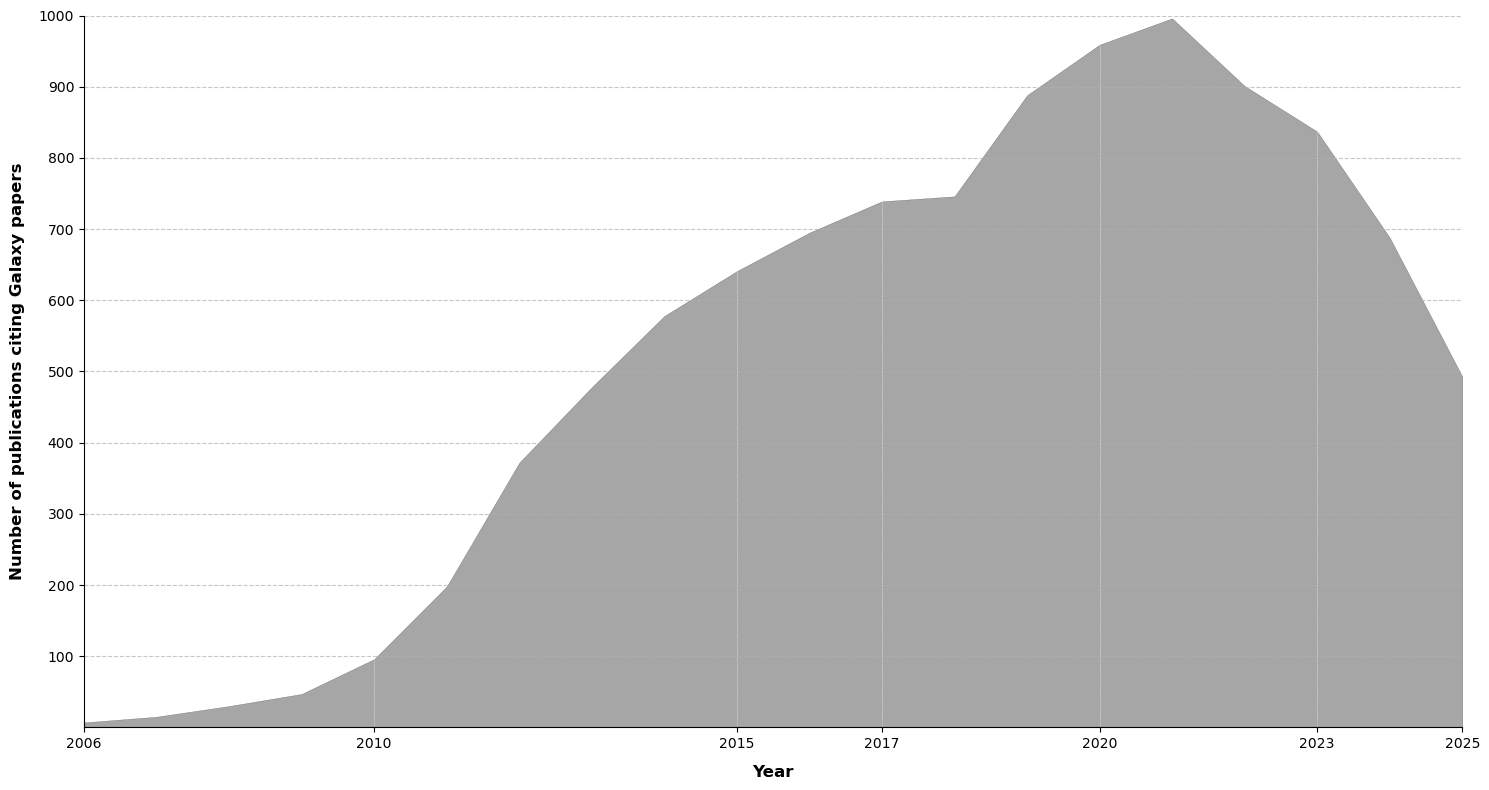

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.fill_between(
    papers_per_year['year'],
    papers_per_year['number'],
    color='grey',
    alpha=0.7,
    linewidth=0.25,
    edgecolor='#404040',
)

# Vertical lines
for year in [2010, 2015, 2017, 2020, 2023]:
    ax.axvline(x=year, color='white', linestyle='dotted', linewidth=0.5)

# X and Y axis
ax.set_xlim(2006, 2025)
ax.set_xticks([2006, 2010, 2015, 2017, 2020, 2023, 2025])
ax.set_yticks(range(100, 1350, 100))
ax.set_ylim(0, 1000)

# Labels
ax.set_xlabel("Year", fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel("Number of publications citing Galaxy papers", fontsize=12, fontweight='bold', labelpad=10)

# Grid
ax.grid(axis='y', linestyle='dashed', alpha=0.7, which='both')
ax.grid(axis='x', which='both', visible=False)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Theme
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

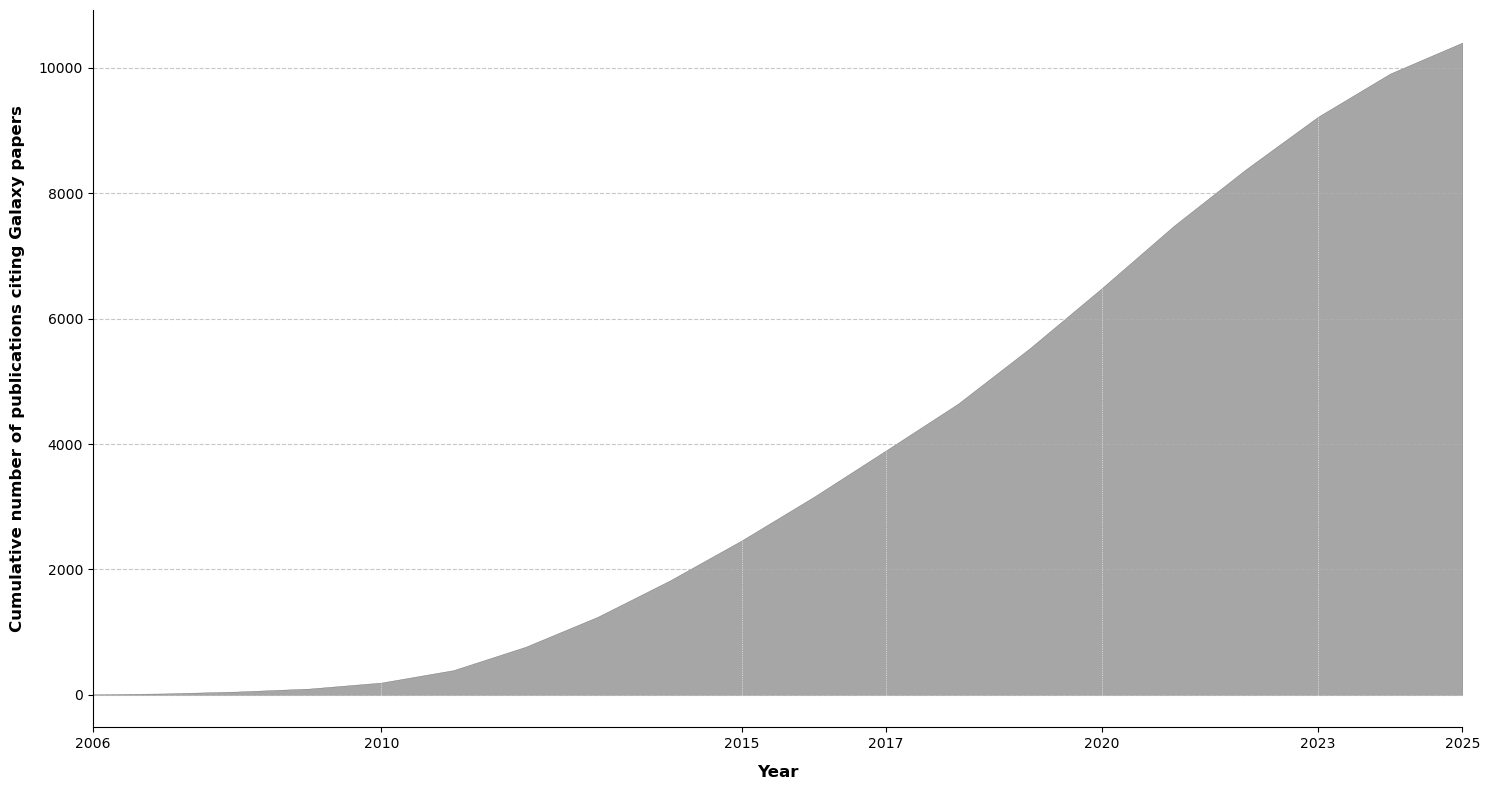

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.fill_between(
    papers_per_year['year'],
    papers_per_year['cumulative_number'],
    color='grey',
    alpha=0.7,
    linewidth=0.25,
    edgecolor='#404040',
)

# Vertical lines
for year in [2010, 2015, 2017, 2020, 2023]:
    ax.axvline(x=year, color='white', linestyle='dotted', linewidth=0.5)

# X and Y axis
ax.set_xlim(2006, 2025)
ax.set_xticks([2006, 2010, 2015, 2017, 2020, 2023, 2025])
#ax.set_yticks(range(100, 1350, 100))

# Labels
ax.set_xlabel("Year", fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel("Cumulative number of publications citing Galaxy papers", fontsize=12, fontweight='bold', labelpad=10)

# Grid
ax.grid(axis='y', linestyle='dashed', alpha=0.7, which='both')
ax.grid(axis='x', which='both', visible=False)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Theme
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

fig.savefig( figure_dp / "cumulative_publications.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()